# EWA algorithm 

We have $m$ predictiors at every time step : $\hat{(y)}_ {(t,i=1,..M)}$. Our goal is to build an algorithm that chooses a predictor $i$ (in an online way) in order to minimize the regret defined implicitly through a loss function $l$.

We implement the following algorithm that updates the probability of choosing a predictor $i$ according to the observer loss.
We algorithm is as follows:

- start with $p_1 = (p_1(1),...,p_1(M)) = (1/M)_{i=1}^M$ a uniform probability of choosing a predictor amoung all predictors.
- At time t : 
    - we know values of all predictors at this time step : $\hat{y}_{(t,1)},...\hat{y}_{(t,M)}$
    - sample an $i(t)$ according to $p_t$ $(\mathbb{P}(i(t) = j) = p_t(j))$
    - choose the following value as our final prediction : $\hat{y}_t = \hat{y}_{(t,i(t))}$ and observe the real value $y_t$
    - Update wheights $$ p_{t+1}(i) = \frac{\exp(-\nu l(\hat{y}_{t,i},y_t) p_t(i))}{\sum_{j}{\exp(-\nu l(\hat{y}_{t,j},y_t))p_t(j)}}$$
    

In [3]:
# Import data

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("donnes_insee.csv",sep = ';')


In [5]:
df.head()

,t,y,c
0,1988Q1,1.2,115.0000
1,1988Q2,0.6,114.6667
2,1988Q3,0.8,116.0000
3,1988Q4,0.4,114.6667
4,1989Q1,1.2,116.3333


In [6]:
yt = np.array(df['y'])
ct = np.array(df['c'])

In [7]:
# Define loss function
def loss(y,y_hat):
    #return 0.5*(y_hat-y)**2;
    return np.abs(y-y_hat)



# Implementation of EWA
# Inputs : a real y, a list of predictors and nu (hyperparameter)
def EWA(y,predictors,nu):
    
    nb_predictors = len(predictors)
    #Nb of predictors
    
    prob_initial = (1/nb_predictors)*np.ones(nb_predictors)
    #Initial uniform probabilties
    
    y_hat = []
    # List of choosen y_hat
    poids_hist = []
    # List of probabilities (evolution time t)
    
    loss_hist = [[0]*nb_predictors]
    # Historic loss (cumulative loss)
    
    
    T = y.shape[0]
    # Horizon 
    
    e = []
    
    for t in range(T):
        poids_hist.append(prob_initial)
        
        y_hat_t = [predictors[j](y,t) for j in range(nb_predictors)]
        e = loss_hist[t]
        loss_hist.append(loss(y[t],y_hat_t)+e)

        
        i = np.random.choice(range(prob_initial.shape[0]), 1, p=prob_initial)
        #Get an element according to probability p         
        
        y_hat.append(y_hat_t[i[0]])
        # Choose the value given by a predictor
        
        
        prob_initial = np.multiply(np.exp(-nu*loss(y_hat_t,y[t])),prob_initial)
        # Update weights
        prob_initial = prob_initial/np.sum(prob_initial)

    return np.array(poids_hist),np.array(loss_hist)

    

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model

# Define predictors according to the lab pdf

def predictor1(y,t):
    if (t == 0): return 0
    else: return y[t-1]
    
def predictior2(y,t):
    return 0.4

def predictor3(y,t):
    return np.asscalar(np.random.normal(0.4,np.sqrt(0.22),1))

regr = linear_model.LinearRegression(fit_intercept=True)

def predictor4(y,t):
    if (t==0): return 0 
    if (t==1): return 0
    else:
        y1 = (y[0:t-1]).reshape(-1,1)
        y2 = (y[1:t]).reshape(-1,1)
        regr.fit(y2, y1)
        return ((regr.intercept_+regr.coef_*y[t-1]).flatten())


def predictor5(y,t):
    if (t==0): return 0 
    if (t==1): return 0
    else:
        y1 = (y[0:t-1]).reshape(-1,1)
        y2 = (ct[1:t]).reshape(-1,1)
        regr.fit(y2, y1)
        return ((regr.intercept_+regr.coef_*ct[t]).flatten())

    
def predictor6(y,t):
    if (t==0): return 0 
    if (t==1): return 0
    else:
        y1 = (y[1:t]).reshape(-1,1)
        y2 = (ct[1:t]).reshape(-1,1)
        y3 = (y[0:t-1]).reshape(-1,1)
        Y = np.hstack((y2,y3))
        regr.fit(Y,y1)
        return ((regr.intercept_+regr.coef_[0][0]*ct[t] + regr.coef_[0][1]*y[t-1]).flatten())
    
#predictor6(yt,50) 
# Train the model using the training sets


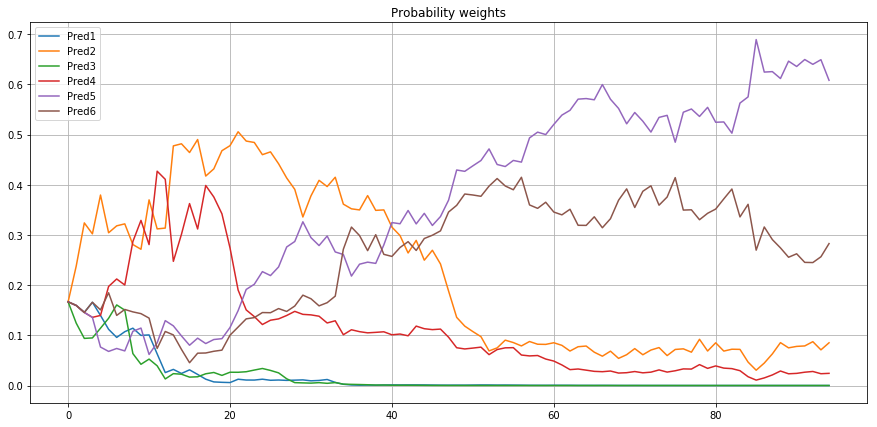

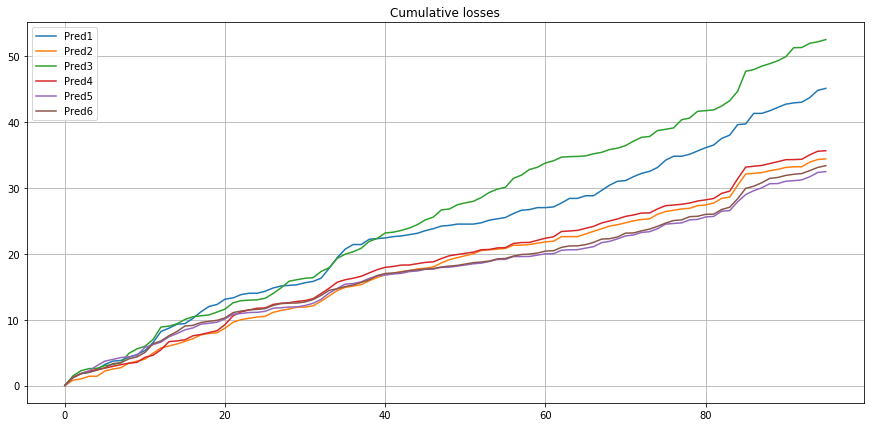

In [10]:
nu = 1

predictors = [predictor1, predictior2,predictor3,predictor4,predictor5,predictor6]

Poids,loss_h = EWA(yt,predictors,nu)
plt.figure(figsize=(15,7))

Labels = ['Pred1','Pred2','Pred3','Pred4','Pred5','Pred6']

#Labels = ['Pred1','Pred2','Pred3']

for poid,lab in zip(Poids.T,Labels):
    plt.plot(poid,label = lab)
plt.legend()
plt.grid(True)
plt.title("Probability weights")
#predictors[0](yt,1)

plt.figure(figsize=(15,7))

for l,lab in zip(loss_h.T,Labels):
    plt.plot(l,label = lab)
plt.legend()
plt.title("Cumulative losses")
plt.grid(True)


